In [8]:
import math
import dimod
import dwave_networkx as dnx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import *
import minorminer
import networkx as nx
import numpy as np
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite

In [2]:
topology_chimera = dnx.chimera_graph(16)
topology_pegasus = dnx.pegasus_graph(16)
topology_zephyr = dnx.zephyr_graph(15)

In [3]:
############### random graphs with random vertex degrees ###############

In [4]:
n = 50
degs = np.arange(n)
m = 3

In [5]:
# constant n vertices, variable edge probability (Chimera)
qubits_chimera = np.zeros_like(degs)
maxchain_chimera = np.zeros_like(degs)

for i, deg in enumerate(degs):
    G = nx.gnp_random_graph(n=n, p=deg/n)

    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_chimera)
        # print(embedding)
        qubits_chimera[i] += sum(map(len, embedding.values()))
        maxchain_chimera[i] += max(map(len, embedding.values()))
    for tensor in [qubits_chimera, maxchain_chimera]:
        tensor[i] /= m

In [ ]:
# constant n vertices, variable avg vertex degree (Pegasus)
# qubits_pegasus = np.zeros_like(degs)
# maxchain_pegasus = np.zeros_like(degs)

for i, deg in enumerate(degs):
    G = nx.gnp_random_graph(n=n, p=deg/n)

    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_pegasus)
        qubits_pegasus[i] += sum(map(len, embedding.values()))
        maxchain_pegasus[i] += max(map(len, embedding.values()))
    for tensor in [qubits_pegasus, maxchain_pegasus]:
        tensor[i] /= m
    print(str(i) + " done")

In [ ]:
# constant n vertices, variable avg vertex degree (Zephyr)
qubits_zephyr = np.zeros_like(degs)
maxchain_zephyr = np.zeros_like(degs)

for i, deg in enumerate(degs):
    G = nx.gnp_random_graph(n=n, p=deg/n)

    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_zephyr)
        qubits_zephyr[i] += sum(map(len, embedding.values()))
        maxchain_zephyr[i] += max(map(len, embedding.values()))
    for tensor in [qubits_zephyr, maxchain_zephyr]:
        tensor[i] /= m
    print(str(i) + " done")

Text(0, 0.5, 'Qubit count')

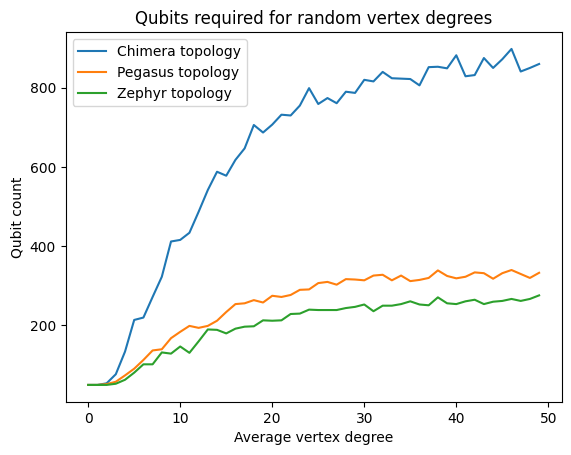

In [11]:
plt.plot(degs, qubits_chimera)
plt.plot(degs, qubits_pegasus)
plt.plot(degs, qubits_zephyr)

plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology"])
plt.title("Qubits required for random vertex degrees")
plt.xlabel("Average vertex degree")
plt.ylabel("Qubit count")
# plt.savefig("qubits-var-deg.png")

[0.9935388812778029, 0.9921429722727492, 0.9877096465435506]


Text(0, 0.5, 'Qubit count')

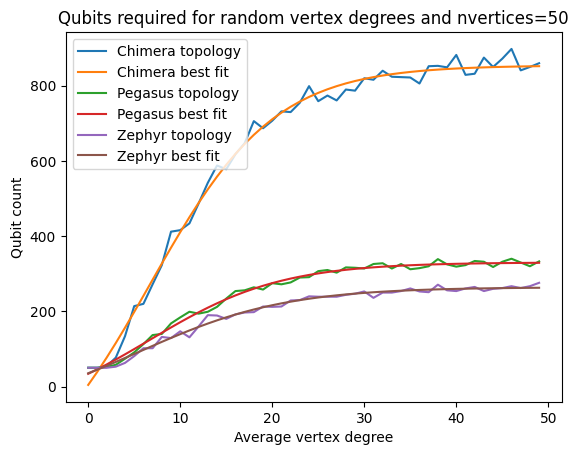

In [12]:
# best fit: S-curve
def logistic(x, L, x_0, k, b):
    return (L / (1 + np.exp(-k * (x - x_0)))) + b

# chimera
L_estimate = qubits_chimera.max()
x_0_estimate = np.median(degs)
k_estimate = 1.0
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, degs, qubits_chimera, p_0)
chimera_fit = logistic(degs, *popt)
plt.plot(degs, qubits_chimera)
plt.plot(degs, chimera_fit)
print("Chimera [L, x_0, k, b]:")
print(*popt)

# pegasus
L_estimate = qubits_pegasus.max()
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, degs, qubits_pegasus, p_0)
pegasus_fit = logistic(degs, *popt)
plt.plot(degs, qubits_pegasus)
plt.plot(degs, pegasus_fit)
print("Pegasus [L, x_0, k, b]:")
print(*popt)

# zephyr
L_estimate = qubits_zephyr.max()
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, degs, qubits_zephyr, p_0)
zephyr_fit = logistic(degs, *popt)
plt.plot(degs, qubits_zephyr)
plt.plot(degs, zephyr_fit)
print("Zephyr [L, x_0, k, b]:")
print(*popt)

# test correlation
corr_matrices = [np.corrcoef(qubits_chimera, chimera_fit), np.corrcoef(qubits_pegasus, pegasus_fit), np.corrcoef(qubits_zephyr, zephyr_fit)]
corrs = [matrix[0,1] for matrix in corr_matrices]
R_sq = [corr**2 for corr in corrs]
print(R_sq)

plt.legend(["Chimera topology", "Chimera best fit", "Pegasus topology", "Pegasus best fit", "Zephyr topology", "Zephyr best fit"])
plt.title("Qubits required for random vertex degrees and nvertices=50")
plt.xlabel("Average vertex degree")
plt.ylabel("Qubit count")
# plt.savefig("qubits-var-deg.png")